In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

from scipy.special import erf

import torch
import torch.nn as nn
import torch.nn.functional as F

from time import time
from time import process_time

import math

In [2]:
def relu(x):
  return x * (x>=0)

def gelu(x):
  return 0.5 * x * (1 + erf(x / np.sqrt(2)))

def gelu_approx(x):
  return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

In [3]:
X = np.linspace(-3, 3, 101)
y_relu = relu(X)
y_gelu = gelu(X)
y_gelu_approx = gelu_approx(X)

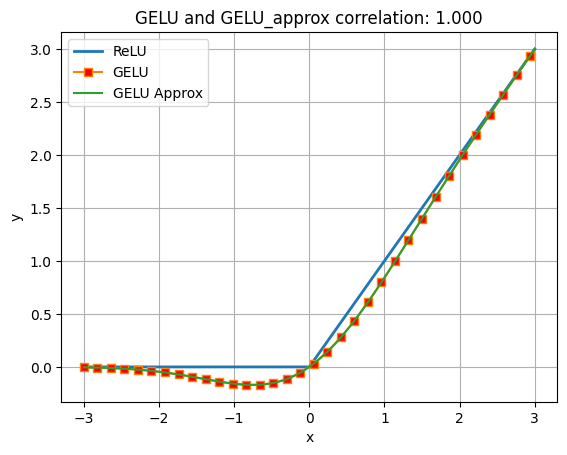

In [4]:
# Plot the functions
plt.plot(X, y_relu, linewidth=2, label='ReLU')
plt.plot(X[::3], y_gelu[::3], markerfacecolor='red', marker='s', label='GELU')
plt.plot(X, y_gelu_approx, label='GELU Approx')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'GELU and GELU_approx correlation: {np.corrcoef(y_gelu, y_gelu_approx)[1,0].item():0.3f}')
plt.grid(True)
plt.show()

# Calculate Relu and Gelu using PyTorch functions

In [5]:
py_relu = F.relu(torch.tensor(X))
py_gelu = F.gelu(torch.tensor(X))

In [6]:
# Calculate the derivatives of the functions
py_relu_diff = torch.diff(py_relu)
py_gelu_diff = torch.diff(py_gelu)

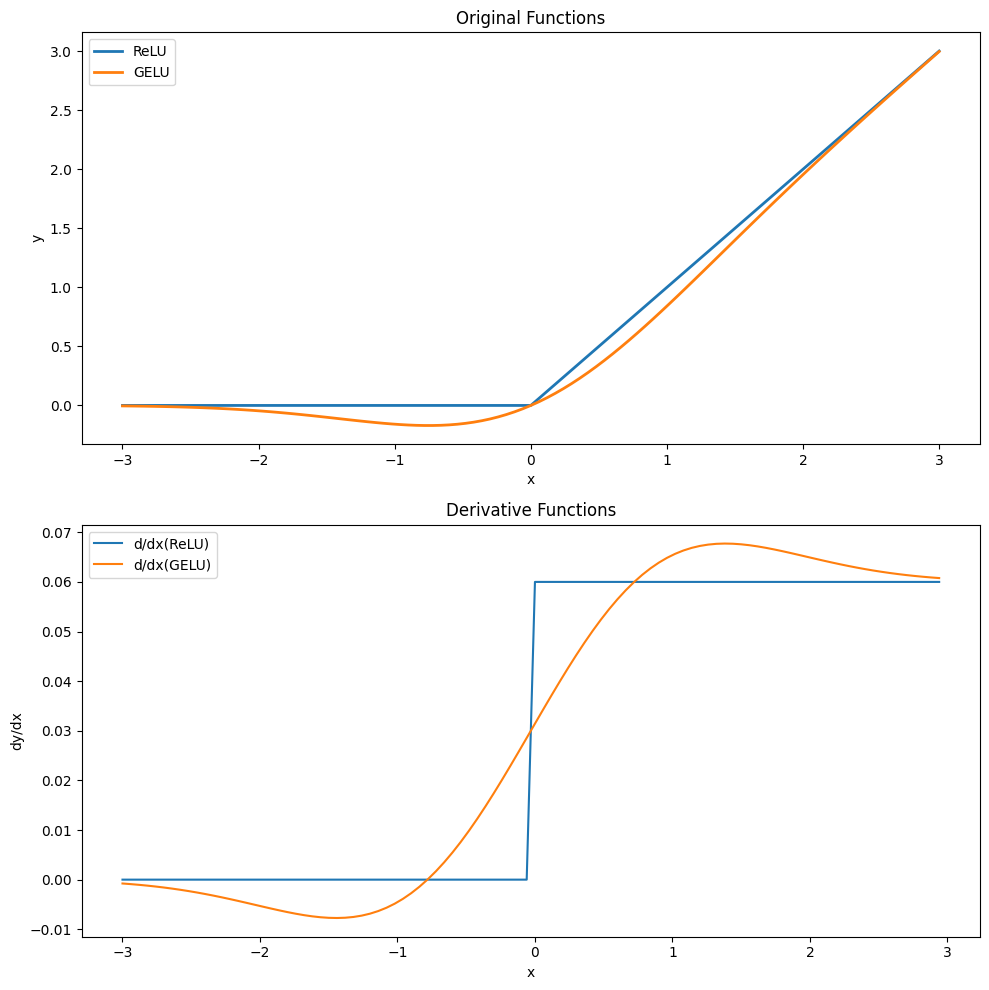

In [7]:
# Plot the original functions and their derivatives
_, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(X, y_relu, linewidth=2, label='ReLU')
axs[0].plot(X, y_gelu, linewidth=2, label='GELU')
axs[0].legend()
axs[0].set_title('Original Functions')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].plot(X[:-1], py_relu_diff.detach().numpy(), label='d/dx(ReLU)')
axs[1].plot(X[:-1], py_gelu_diff.detach().numpy(), label='d/dx(GELU)')
axs[1].legend()
axs[1].set_title('Derivative Functions')
axs[1].set_xlabel('x')
axs[1].set_ylabel('dy/dx')

plt.tight_layout()
plt.show()

# Computre ReLU and GeLu using PyTorch classes

In [8]:
relu_class = nn.ReLU()
gelu_class = nn.GELU()

py_relu_class = relu_class(torch.tensor(X))
py_gelu_class = gelu_class(torch.tensor(X))

In [9]:
# Show that the outputs are the same
(py_relu_class - py_relu).sum().item(), (py_gelu_class - py_gelu).sum().item()

(0.0, 0.0)

# Timing the functions

In [10]:
X = np.linspace(-3, 3, 10001)

relu_time = %timeit -o -n 10000 relu(X)
gelu_time = %timeit -o -n 10000 gelu(X)
gelu_approx_time = %timeit -o -n 10000 gelu_approx(X)

14.3 µs ± 253 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
197 µs ± 381 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
911 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
X = np.linspace(-3, 3, 10001)

relu_time = %timeit -o [relu(X) for _ in range(10000)]
gelu_time = %timeit -o [gelu(X) for _ in range(10000)]
gelu_approx_time = %timeit -o [gelu_approx(X) for _ in range(10000)]

549 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.36 s ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.5 s ± 6.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test the results on GPU

In [17]:
# Redefine the functions using pytorch and math

# Redefine the functions using pytorch for tensor operations
def relu(x):
  return x * (x>=0)

def gelu(x):
  # Use torch.erf for PyTorch tensors
  return 0.5 * x * (1 + torch.erf(x / math.sqrt(2)))

def gelu_approx(x):
  # Convert the float constant to a tensor before passing to torch.sqrt
  return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * x**3)))

In [28]:
# Test random numbers on CPU

X = torch.rand(1_000_000, device='cpu')
iter = 1000

print('-------------On CPU----------------')
start_time = process_time()

for _ in range(iter): relu(X)
print(f'ReLU: {process_time() - start_time:0.3f} seconds')

start_time = process_time()
for _ in range(iter): gelu(X)
print(f'GELU: {process_time() - start_time:0.3f} seconds')

start_time = process_time()
for _ in range(iter): gelu_approx(X)
print(f'GELU Approx: {process_time() - start_time:0.3f} seconds')

start_time = process_time()
for _ in range(iter): F.gelu(X)
print(f'Built-in GELU: {process_time() - start_time:0.3f} seconds')

-------------On CPU----------------
ReLU: 2.882 seconds
GELU: 5.125 seconds
GELU Approx: 5.130 seconds
Built-in GELU: 0.774 seconds


In [25]:
# Test random numbers now on GPU

X = torch.rand(1_000_000, device='cuda')
iter = 1000

print('-------------On GPU----------------')
torch.cuda.synchronize()
start_time = process_time()

for _ in range(iter): relu(X)
print(f'ReLU: {process_time() - start_time:0.3f} seconds')

torch.cuda.synchronize()
start_time = process_time()
for _ in range(iter): gelu(X)
print(f'GELU: {process_time() - start_time:0.3f} seconds')

torch.cuda.synchronize()
start_time = process_time()
for _ in range(iter): gelu_approx(X)
print(f'GELU Approx: {process_time() - start_time:0.3f} seconds')

torch.cuda.synchronize()
start_time = process_time()
for _ in range(iter): F.gelu(X)
print(f'Built-in GELU: {process_time() - start_time:0.3f} seconds')

-------------On GPU----------------
ReLU: 0.021 seconds
GELU: 0.053 seconds
GELU Approx: 0.105 seconds
Built-in GELU: 0.009 seconds
